# Consumer Complaints Classification with LSTM

This script looks into the consumer complaints from banks in California. It applies LSTM on complaint classification and figures out the products consumers are not satisfied with. 

In [1]:
import pandas as pd 

OUTPUT_FOLDER = os.getcwd() + '/output/'

data = pd.read_excel('ca_data.xlsx')
df = (pd.DataFrame(data, columns = ['product','consumer_complaint_narrative'])
        .dropna()
        .set_axis(['product', 'complaint'], axis = 1, inplace = False)
        .reset_index(drop = True))

## regroup product labels
df['product'] = df['product'].replace({
    'Consumer Loan': 'Others',
    'Payday loan': 'Others',
    'Student loan': 'Others',
    'Prepaid card': 'Bank account or service',
    'Money transfers': 'Others',
    'Other financial service': 'Others',
    'Credit card': 'Credit card & credit reporting',
    'Credit reporting': 'Credit card & credit reporting',
    'Bank account and service': 'Others'
})

df.head()

,product,complaint
0,Mortgage,In XX/XX/XXXX my wages that I earned at my job...
1,Mortgage,I have an open and current mortgage with Chase...
2,Mortgage,XXXX was submitted XX/XX/XXXX. At the time I s...
3,Mortgage,Experian is reporting my OPEN and CURRENT Mort...
4,Mortgage,This complaint is against Wells Fargo Bank for...


## Text Pre-processing

- Remove stop words
- Tokenize, convert to lower case and remove punctuation
- Stem tokens using PorterStemmer


In [2]:
from gensim.utils import simple_preprocess
from gensim.parsing.porter import PorterStemmer
from gensim.parsing.preprocessing import remove_stopwords

porter_stemmer = PorterStemmer()

## function to clean raw text
def clean_txt(message):

    ### remove xxx
    message = message.replace('xx', '')

    ### remove stop words
    message_no_stopwrd = remove_stopwords(message)

    ### simple preprocess
    tokens = simple_preprocess(message_no_stopwrd, deacc = True)

    ### stemming tokens
    tokens_stemmed = [porter_stemmer.stem(token) for token in tokens]

    return tokens_stemmed

## print raw text after cleaning 
df_token = df.assign(tokens = df['complaint'].apply(lambda x: clean_txt(x)))
df_token['complaint'] = [' '.join(token) for token in df_token['tokens']]
df_token.head()

,product,complaint,tokens
0,Mortgage,in xx xx xxxx wage earn job decreas half xx xx...,"[in, xx, xx, xxxx, wage, earn, job, decreas, h..."
1,Mortgage,open current mortgag chase bank xxxx chase rep...,"[open, current, mortgag, chase, bank, xxxx, ch..."
2,Mortgage,xxxx submit xx xx xxxx at time submit complain...,"[xxxx, submit, xx, xx, xxxx, at, time, submit,..."
3,Mortgage,experian report open current mortgag loan xxxx...,"[experian, report, open, current, mortgag, loa..."
4,Mortgage,thi complaint well fargo bank violat term cond...,"[thi, complaint, well, fargo, bank, violat, te..."


## Exploring Data
### Inbalanced samples

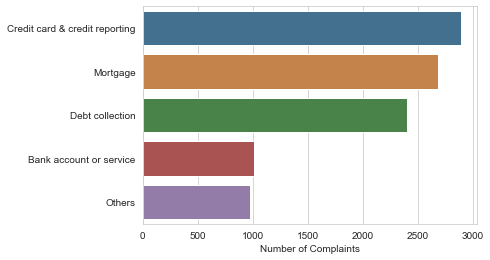

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
ax = sns.countplot(y = 'product', data = df_token, saturation = 0.5, order = df_token['product'].value_counts().index)
ax.set(xlabel = 'Number of Complaints', ylabel = '')
plt.show()

## Word Cloud

In [4]:
from wordcloud import WordCloud

## function to generate word cloud
def word_cloud_plotter(review_column):
  
    ### generate word cloud
    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color = 'white', 
                    min_font_size = 10).generate(str(review_column)) 
    
    ### plot word cloud
    plt.figure(figsize = (5, 5), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    
    plt.show() 

### (1) Mortgage

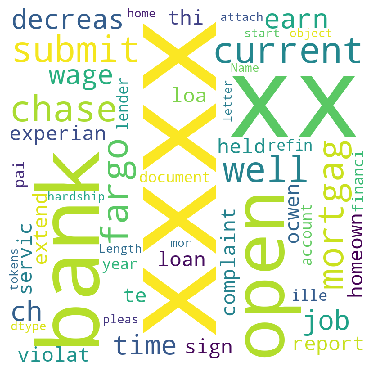

In [5]:
word_cloud_plotter(df_token.query('product == "Mortgage"')['tokens'])

### (2) Bank Account or Service

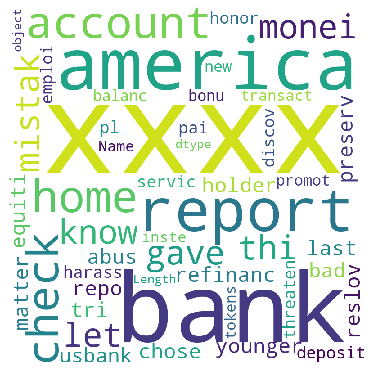

In [6]:
word_cloud_plotter(df_token.query('product == "Bank account or service"')['tokens'])

## Word Embeddings
### (1) Word2Vec Models

In [8]:
from gensim.models import Word2Vec

## function to train models for work embeddings
def save_wEmbed(model_type, tokens):

    ### set up output folder
    word2vec_model_file = OUTPUT_FOLDER + 'word2vec_' + model_type + '.model'

    ### set up parameters
    size = 1000
    window = 3
    min_count = 1
    workers = 3
    sg = int(model_type == 'sGram')

    ### train model
    w2v_model = Word2Vec(tokens, 
                         min_count = min_count, 
                         size = size, 
                         workers = workers, 
                         window = window, 
                         sg = 1)
    ### save model 
    w2v_model.save(word2vec_model_file)

In [9]:
# # extract tokens to fit 
# stemmed_tokens = pd.Series(df_token['complaint']).values

# # save CBOW
# save_wEmbed('CBOW', stemmed_tokens)

# # save skip-gram
# save_wEmbed('sGram', stemmed_tokens)

### (2) Word2Vec CBOW & skip-gram

In [10]:
import numpy as np

## function to write vectorized reviews using work2vec model
def save_X_word2vec(model_type):

    ### set up output filename
    word2vec_filename = OUTPUT_FOLDER + 'X_word2vec_' + model_type + '.csv' 

    ### load word2vec model 
    w2v_model = Word2Vec.load(OUTPUT_FOLDER + 'word2vec_' + model_type + '.model')

    ### write csv file 
    with open(word2vec_filename, 'w+') as word2vec_file:
        for index, row in df_token.iterrows():
            model_vector = (np.mean([w2v_model[token] for token in row['complaint']], axis=0)).tolist()
            if index == 0:
                header = ",".join(str(ele) for ele in range(1000))
                word2vec_file.write(header)
                word2vec_file.write("\n")
            # Check if the line exists else it is vector of zeros
            if type(model_vector) is list:  
                line1 = ",".join( [str(vector_element) for vector_element in model_vector] )
            else:
                line1 = ",".join([str(0) for i in range(1000)])
            word2vec_file.write(line1)
            word2vec_file.write('\n')


# save_X_word2vec('CBOW')
# save_X_word2vec('sGram')

# X_cbow = pd.read_csv(OUTPUT_FOLDER + 'X_word2vec_CBOW.csv')
# X_sgram = pd.read_csv(OUTPUT_FOLDER + 'X_word2vec_sGram.csv')

## Modeling 
### (1) Sequence and pad complaints

In [11]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

## split training and testing 
data_train, data_test = train_test_split(df_token, test_size = 0.20, random_state = 2020)

## sequence of token index to represent sentence - training 
max_vocab = 50000
tokenizer = Tokenizer(num_words = max_vocab, lower = True, char_level = False)
tokenizer.fit_on_texts(data_train["tokens"].tolist())
training_sequences = tokenizer.texts_to_sequences(data_train["tokens"].tolist())
train_word_index = tokenizer.word_index

## pad sequence - training 
max_sequence_length = 400
embedding_dim = 1000
train_cnn_data = pad_sequences(training_sequences, maxlen = max_sequence_length)

## sequence & pad - testing 
test_sequences = tokenizer.texts_to_sequences(data_test["tokens"].tolist())
test_cnn_data = pad_sequences(test_sequences, maxlen = max_sequence_length)

## get dummies for complaint labels
y_train = pd.get_dummies(data_train['product']).values
y_test = pd.get_dummies(data_test['product']).values

Using TensorFlow backend.


### (2) Set up rnn using pretrained embeddings weights 

In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


## function to get embedding weights
def get_word2vec_weights(model_type):
    word_model = Word2Vec.load(OUTPUT_FOLDER + 'word2vec_' + model_type + '.model')
    train_embedding_weights = np.zeros((len(train_word_index) + 1, embedding_dim))
    for word, index in train_word_index.items():
        train_embedding_weights[index,:] = word_model[word] if word in word_model else np.random.rand(embedding_dim)
    return train_embedding_weights


## function to setup rnn
def rnn(embeddings, max_sequence_length, num_words, embedding_dim, labels_index):
    model = keras.Sequential(
        [
            layers.Input(shape=(max_sequence_length), dtype='int32'),
            layers.Embedding(num_words,
                             embedding_dim,
                             weights=[embeddings],
                             input_length=max_sequence_length,
                             trainable=False),
            layers.LSTM(256),
            layers.Dense(128, activation='relu'),
            layers.Dense(0.2),
            layers.Dropout(0.2),
            layers.Dense(labels_index, activation = 'softmax')
        ]
    )
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model   

### (3) Model with CBOW 

In [13]:
## set up rnn using skip-gram 
model = rnn(
    embeddings = get_word2vec_weights('CBOW'),
    max_sequence_length = max_sequence_length, 
    num_words = len(train_word_index) + 1, 
    embedding_dim = embedding_dim,
    labels_index = len(list(df_token['product'].unique()))
)

## train rnn model
history = model.fit(
    train_cnn_data, 
    y_train, 
    epochs = 5, 
    validation_split = 0.1, 
    shuffle = True, 
    batch_size = 34
)

## predict on testing
accr = model.evaluate(test_cnn_data, y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0], accr[1]))

Epoch 1/5
212/212 [==============================] - 305s 1s/step - loss: 1.6094 - accuracy: 0.1026 - val_loss: 1.6094 - val_accuracy: 0.0939
Epoch 2/5
147/212 [===================>..........] - ETA: 1:31 - loss: 1.6094 - accuracy: 0.1026

### (4) Model with skip-Gram

In [14]:
## set up rnn using skip-gram 
model = rnn(
    embeddings = get_word2vec_weights('sGram'),
    max_sequence_length = max_sequence_length, 
    num_words = len(train_word_index) + 1, 
    embedding_dim = embedding_dim,
    labels_index = len(list(df_token['product'].unique()))
)

## train rnn model
history = model.fit(
    train_cnn_data, 
    y_train, 
    epochs = 5, 
    validation_split = 0.1, 
    shuffle = True, 
    batch_size = 34
)

## predict on testing
accr = model.evaluate(test_cnn_data, y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0], accr[1]))

NameError: name 'train_word_index' is not defined